# CIC prediction

In [1]:
from warnings import simplefilter
simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

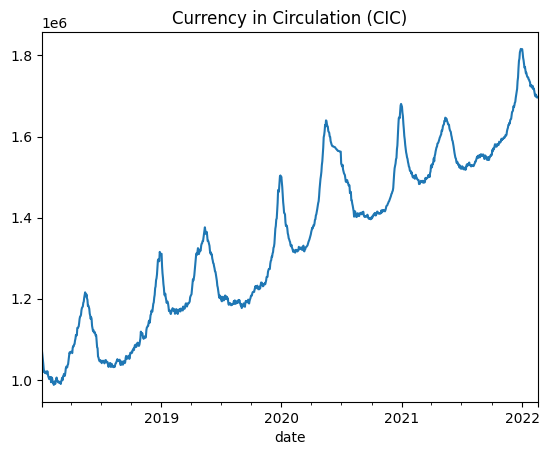

In [4]:
data = pd.read_excel('../data/CIC.xlsx', parse_dates=['date'], index_col='date')
data['CIC'].plot(title = 'Currency in Circulation (CIC)'); plt.show()

## Section 2: Model Definition

In [5]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS,
    StatsForecastAutoCES, 
    StatsForecastAutoTheta,
    StatsForecastMSTL,
    StatsForecastAutoTBATS,
)
from sktime.forecasting.fbprophet import Prophet

In [6]:
ForecastingModels = {
    "Naive": NaiveForecaster(),
    "Seasonal_Naive": NaiveForecaster(sp = 5),
    "AutoARIMA": StatsForecastAutoARIMA(
                    trend=True, seasonal=True,
                    max_D = 262, max_p= 10, max_q=10),
    "AutoETS": StatsForecastAutoETS(season_length=262),
    "AutoCES": StatsForecastAutoCES(season_length=262),
    "AutoTheta": StatsForecastAutoTheta(season_length=262),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=262, use_trend =True, use_boxcox=True),
    "LOESS": StatsForecastMSTL(season_length=262),
    "Prophet": Prophet(yearly_seasonality=True, weekly_seasonality=True),
}
from forecast_combine import model_select as f
#import imp; imp.reload(f)
model = f.ForecastModelSelect(
            data= data,
            depvar_str = 'CIC',                 
            exog_l=None,
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            models_d = ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            nbest = 2)

### Cross validation Procedure

Number of Folds      : 53
Initial Window Size  : 808
Step Length          : 5
Forecast Horizon     : 10
First Cutoff         : 2021-02-05 00:00:00
Last Curoff          : 2022-02-04 00:00:00


<Axes: title={'center': 'Cross Validation Procedure'}, ylabel='Window number'>

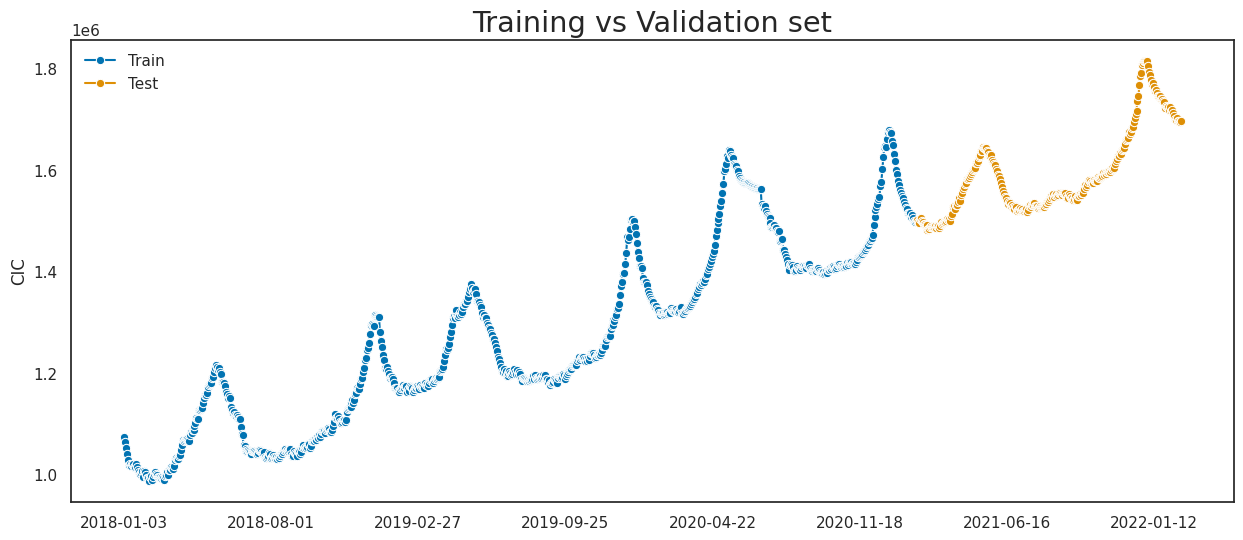

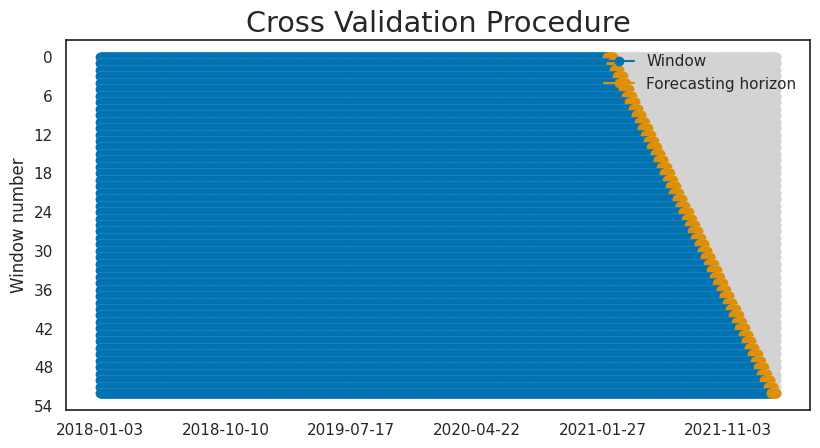

In [7]:
_ = model.split_procedure_summary()

model.plot_train_test(
    labels = ['Train', 'Test'],
    title='Training vs Validation set')

model.plot_cv_procedure(xlabel='')

### Out-Of-sample Evaluation

In [8]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evalution....


Evaluation completed in: 0.035 minutes

Start Seasonal_Naive forecaster evalution....
Evaluation completed in: 0.019 minutes

Start AutoARIMA forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/

Evaluation completed in: 0.333 minutes

Start AutoETS forecaster evalution....
Evaluation completed in: 0.564 minutes

Start AutoCES forecaster evalution....
Evaluation completed in: 0.472 minutes

Start AutoTheta forecaster evalution....
Evaluation completed in: 0.336 minutes

Start AutoTBATS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated

Evaluation completed in: 0.452 minutes

Start LOESS forecaster evalution....
Evaluation completed in: 0.557 minutes

Start Prophet forecaster evalution....
Evaluation completed in: 0.053 minutes


In [9]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoCES,53,22.74466,0.251231,808,1068,2021-02-05,2022-02-04,11736.409383,10351.165386,0.006465,-5.535221,10129.646862
AutoETS,53,28.615989,0.193625,808,1068,2021-02-05,2022-02-04,13899.218382,11894.001577,0.00732,-2.776147,11192.280134
AutoTBATS,53,16.197264,0.005082,808,1068,2021-02-05,2022-02-04,15869.729296,13758.236982,0.008508,-7.814631,13367.510684
Prophet,53,0.519134,0.09844,808,1068,2021-02-05,2022-02-04,16288.987279,15144.349911,0.009385,-11.572382,14919.609712
AutoTheta,53,13.29735,0.206147,808,1068,2021-02-05,2022-02-04,17505.52317,15425.711792,0.009453,-3.293195,15357.893868
Naive,53,0.002711,0.04192,808,1068,2021-02-05,2022-02-04,17816.870378,15701.801887,0.009626,-3.532311,15665.179245
AutoARIMA,53,15.094151,1.025645,808,1068,2021-02-05,2022-02-04,18069.573562,15859.745683,0.00976,-5.161888,15722.68686
LOESS,53,10.155348,0.303187,808,1068,2021-02-05,2022-02-04,18747.25357,17600.862926,0.011043,-14.914763,17462.988526
Seasonal_Naive,53,0.002665,0.034437,808,1068,2021-02-05,2022-02-04,21920.786592,20079.00566,0.012277,-6.462239,19660.830189


horizon                            1             2             3   \
Naive          RMSE       6008.811746   8493.850495  13120.374519   
               MAE        4450.905660   6590.641509   9694.245283   
               MAPE          0.002785      0.004090      0.005963   
               R2            0.994958      0.990023      0.976194   
               MedianAE   3003.000000   5309.000000   9074.000000   
Seasonal_Naive RMSE      19205.503930  18581.998451  18544.130069   
               MAE       14052.886792  13365.018868  13825.603774   
               MAPE          0.008619      0.008181      0.008464   
               R2            0.948491      0.952249      0.952443   
               MedianAE  10717.000000   9690.000000  11152.000000   
AutoARIMA      RMSE       6633.621347   9203.312847  13379.826380   
               MAE        4926.183582   6918.513939   9973.135662   
               MAPE          0.003093      0.004329      0.006179   
               R2            0.993855      0.988287      0.975243   
               MedianAE   3158.599778   5659.762965   7567.053158   
AutoETS        RMSE       5003.855236   6225.814753   9879.337975   
               MAE        3800.318608   4850.538741   6255.095701   
               MAPE          0.002399      0.003051      0.003881   
               R2            0.996503      0.994640      0.986502   
               MedianAE   2929.196935   4424.223616   3945.794621   
AutoCES        RMSE       5640.593184   7374.505492   9317.587558   
               MAE        4716.899898   5746.498554   7139.779794   
               MAPE          0.002974      0.003593      0.004460   
               R2            0.995557      0.992479      0.987994   
               MedianAE   4403.492188   4035.523438   5598.382812   
AutoTheta      RMSE       5894.175275   8314.734584  12967.891004   
               MAE        4342.933962   6482.084906   9548.728774   
               MAPE          0.002716      0.004019      0.005870   
               R2            0.995148      0.990439      0.976744   
               MedianAE   3268.875000   5322.500000   8112.750000   
AutoTBATS      RMSE       5204.797533   6757.702261  10144.969860   
               MAE        4265.545608   5666.269844   7806.549784   
               MAPE          0.002689      0.003552      0.004855   
               R2            0.996217      0.993685      0.985767   
               MedianAE   3973.102900   5453.431126   6939.716774   
LOESS          RMSE      14786.406063  16153.814676  17286.835021   
               MAE       13428.201839  14675.691746  15214.174020   
               MAPE          0.008428      0.009214      0.009558   
               R2            0.969468      0.963914      0.958673   
               MedianAE  13622.443369  14879.530043  15387.849097   
Prophet        RMSE      16816.512224  16770.022882  17239.135920   
               MAE       12555.358569  12638.107309  13298.393293   
               MAPE          0.007764      0.007810      0.008255   
               R2            0.960509      0.961108      0.958901   
               MedianAE  10381.182985   9823.854419  10583.734278   

horizon                            4             5             6   \
Naive          RMSE      17052.199580  18969.734289  23101.171284   
               MAE       12542.660377  14297.735849  17128.396226   
               MAPE          0.007699      0.008756      0.010475   
               R2            0.960002      0.950206      0.926214   
               MedianAE  10558.000000  13731.000000  14945.000000   
Seasonal_Naive RMSE      19116.543085  18969.734289  34904.199685   
               MAE       14342.283019  14297.735849  26444.000000   
               MAPE          0.008786      0.008756      0.016144   
               R2            0.949732      0.950206      0.831554   
               MedianAE  10720.000000  13731.000000  20159.000000   
AutoARIMA      RMSE      16316.908475  18493.296072  22649.364565 

In [10]:
rank, score = model.select_best(score = 'MAPE')
display(rank)
display(score)

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,AutoETS,AutoETS,AutoETS,AutoCES,AutoETS,AutoCES,AutoCES,AutoCES,AutoCES,AutoCES
Best_2,AutoTBATS,AutoTBATS,AutoCES,AutoETS,AutoCES,AutoETS,AutoETS,AutoETS,Prophet,Prophet
Best_3,AutoTheta,AutoCES,AutoTBATS,AutoTBATS,AutoTBATS,AutoTBATS,Prophet,Prophet,AutoETS,AutoETS
Best_4,Naive,AutoTheta,AutoTheta,AutoTheta,Prophet,AutoTheta,AutoTBATS,AutoTBATS,LOESS,LOESS
Best_5,AutoCES,Naive,Naive,Naive,AutoTheta,AutoARIMA,AutoTheta,LOESS,AutoTBATS,AutoTBATS
Best_6,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,Prophet,Naive,AutoTheta,AutoTheta,AutoTheta
Best_7,Prophet,Prophet,Prophet,Prophet,Naive,Naive,AutoARIMA,Naive,Naive,AutoARIMA
Best_8,LOESS,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,LOESS,LOESS,AutoARIMA,AutoARIMA,Naive
Best_9,Seasonal_Naive,LOESS,LOESS,LOESS,LOESS,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive


,Naive,Seasonal_Naive,AutoARIMA,AutoETS,AutoCES,AutoTheta,AutoTBATS,LOESS,Prophet,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,,,,,
1,0.002785,0.008619,0.003093,0.002399,0.002974,0.002716,0.002689,0.008428,0.007764,0.002974,0.002399,0.002687,0.002544,0.004607
2,0.004090,0.008181,0.004329,0.003051,0.003593,0.004019,0.003552,0.009214,0.007810,0.003593,0.003051,0.003322,0.003302,0.005315
3,0.005963,0.008464,0.006179,0.003881,0.004460,0.005870,0.004855,0.009558,0.008255,0.004460,0.003881,0.004170,0.004170,0.006387
4,0.007699,0.008786,0.007741,0.005502,0.005426,0.007601,0.006045,0.009438,0.008229,0.005426,0.005426,0.005464,0.005464,0.007385
5,0.008756,0.008756,0.008722,0.006144,0.006179,0.008587,0.007565,0.010481,0.008365,0.006179,0.006144,0.006161,0.006161,0.008173
6,0.010475,0.016144,0.010251,0.007604,0.007205,0.010200,0.009259,0.011540,0.010313,0.007205,0.007205,0.007404,0.007404,0.010332
7,0.011880,0.015949,0.012041,0.008892,0.007553,0.011478,0.010576,0.012369,0.010455,0.007553,0.007553,0.008222,0.008222,0.011244
8,0.013559,0.015931,0.013985,0.010717,0.008495,0.013376,0.012223,0.012666,0.010967,0.008495,0.008495,0.009606,0.009606,0.012436
9,0.015100,0.015984,0.015403,0.012098,0.008822,0.015020,0.013451,0.012889,0.010810,0.008822,0.008822,0.010460,0.009816,0.013286


<Axes: title={'center': 'Out of Sample Performance'}, xlabel='horizon', ylabel='MAE'>

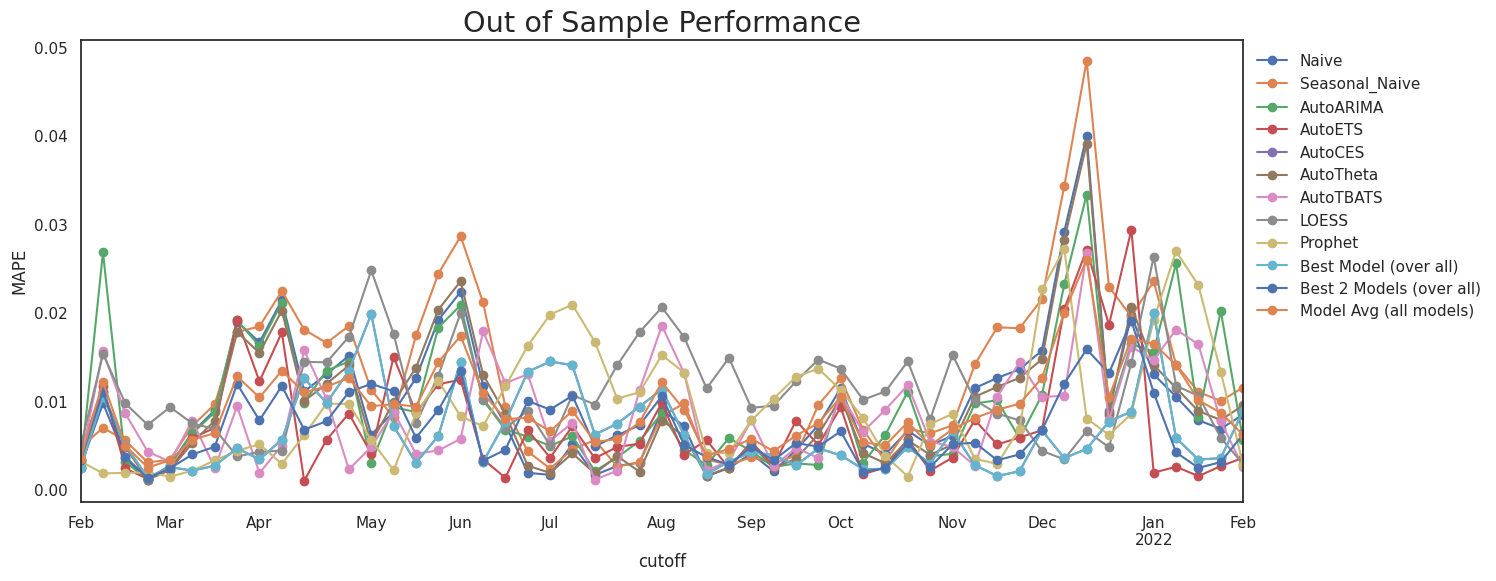

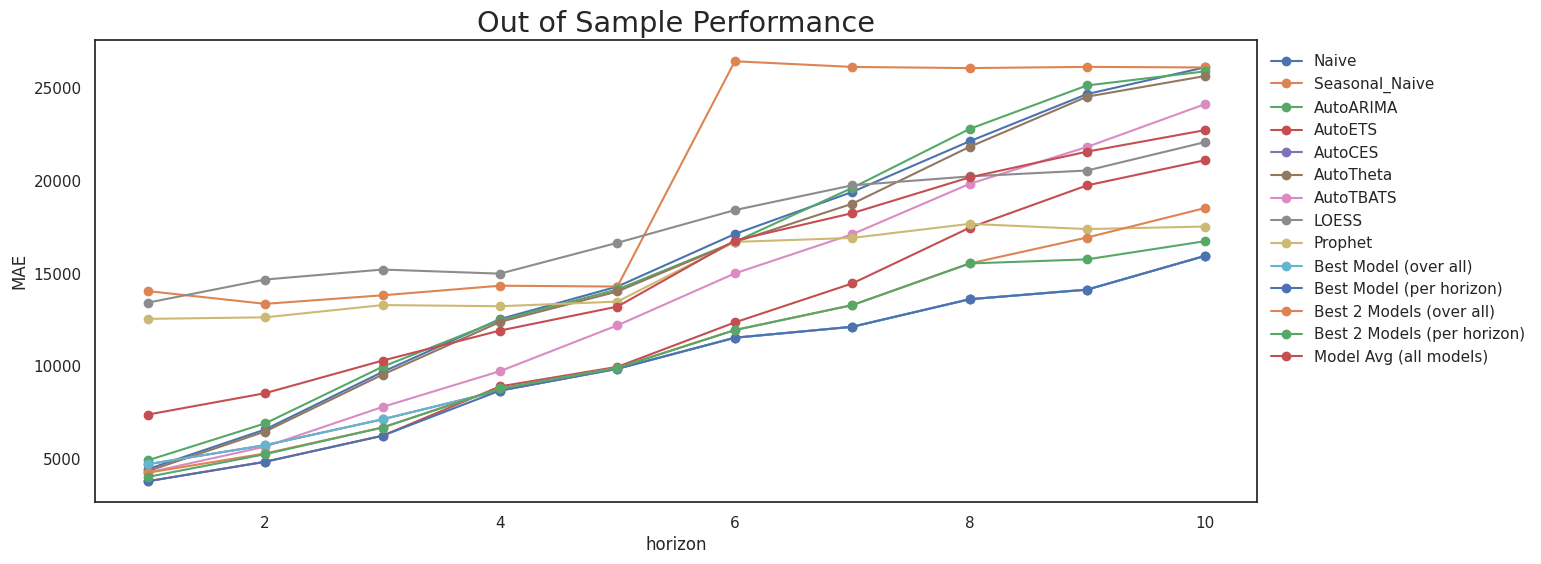

In [11]:
subset = ['AutoETS', 'AutoCES', 'AutoTBATS', 'Prophet','Model Avg (all models)']
model.plot_model_compare(score ='MAPE', view = 'cutoff')#, model_subset=subset)
model.plot_model_compare(score ='MAE', view = 'horizon')#, model_subset=subset + ['Best Model (per horizon)'])

Fitting Naive ...
Fitting Seasonal_Naive ...
Fitting AutoARIMA ...


Fitting AutoETS ...
Fitting AutoCES ...
Fitting AutoTheta ...
Fitting AutoTBATS ...
Fitting LOESS ...


14:17:29 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet ...


14:17:29 - cmdstanpy - INFO - Chain [1] done processing


LOESS does not support prediction intervals
Error: StatsForecastMSTL does not have the capability to return prediction intervals. If you think this estimator should have the capability, please open an issue on sktime.


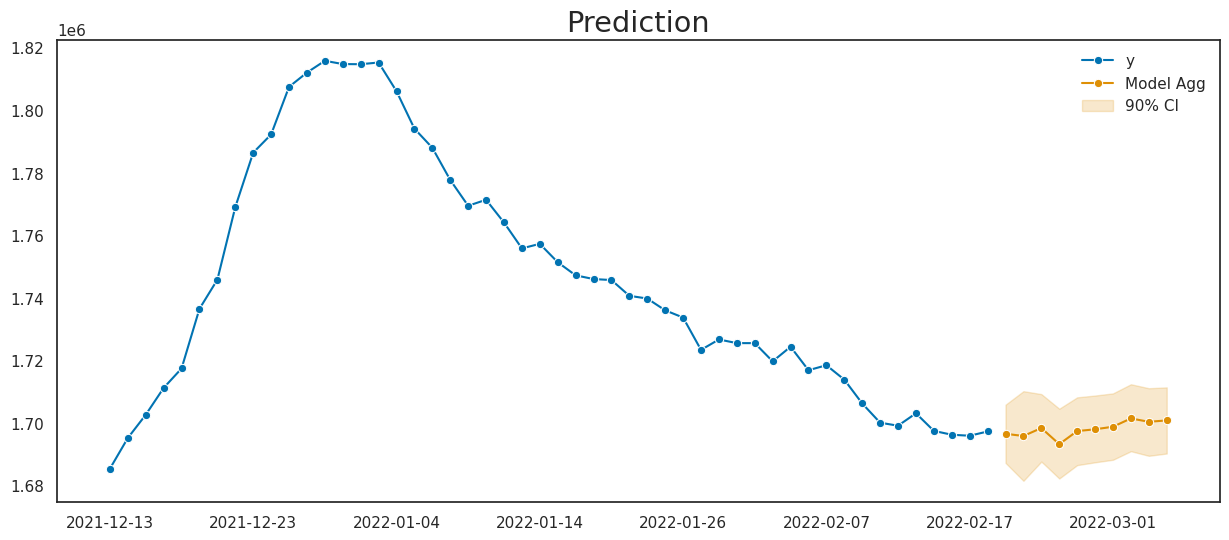

In [12]:
model.fit(verbose = True)
y_pred, y_pred_ints, preds, pred_ints = model.predict(mode='best_horizon', ret_underlying=True)
f, ax =model.plot_prediction(y_pred = y_pred,
                     models_preds = None,
                     y_pred_interval = y_pred_ints)  

LOESS does not support prediction intervals
Error: StatsForecastMSTL does not have the capability to return prediction intervals. If you think this estimator should have the capability, please open an issue on sktime.


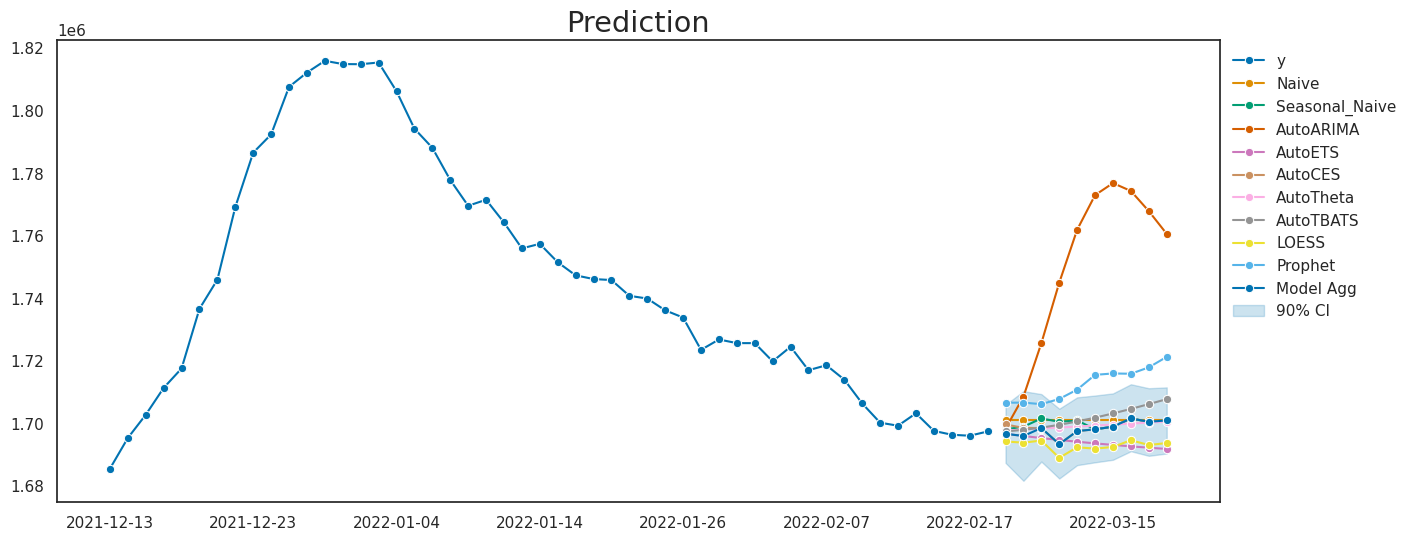

In [13]:
newdata = pd.concat([data, 
                     y_pred.rename('CIC').to_frame()
                    ])
y_pred, y_pred_ints, preds, pred_ints = model.update(newdata=newdata, 
                                                     mode='best_horizon',
                                                     ret_underlying=True)
f, ax = model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)  

In [14]:
path = '../model_output/CIC_forecast.pkl'
model.save(path)